# **House Prices - Advanced Regression Techniques** 

(https://www.kaggle.com/competitions/house-prices-advanced-regression-techniques/) - *projekt na Uczenie Maszynowe*

*by Bartosz Rogowski & Aleksandra Rolka*


In [1]:
# running from Google collab
# -----------------------------------------------------------------
# from google.colab import drive
# drive.mount('/content/drive')

# !unzip drive/Shareddrives/ML-team/house-prices-advanced-regression-techniques.zip -d data
# data_folder_path = '/content/data'


# running locally
# -----------------------------------------------------------------
data_folder_path = './data/'

In [ ]:
!pip install shap

In [37]:
import pandas as pd
from pandas.api.types import is_numeric_dtype
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from math import isnan
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
from sklearn.metrics import make_scorer
import shap
from collections import Counter, OrderedDict

## Przygotowanie danych

In [38]:
def encode_not_numeric_collumns(df):
  for column_name in df:
    if not is_numeric_dtype(df[column_name]):
      unique_values_dict = dict(enumerate(df[column_name].unique()))
      unique_values_dict = dict((v, k) for k, v in unique_values_dict.items())
      df[column_name] = df[column_name].map(unique_values_dict)
  return df

In [39]:
def convert_Nan_values(df, target_value=0):
  for column_name in df:
    df[column_name] = df[column_name].fillna(target_value)
  return df

In [40]:
def normalize_dataframe(df, columns_names):
    scaler = MinMaxScaler()
    df[columns_names] = scaler.fit_transform(df[columns_names])
    return df

In [41]:
def columns_to_drop_too_many_NaN(df, treshold=0.15):
  columns_names = []
  for column_name in df:
    count = sum(pd.isnull(df[column_name]))
    if count/len(df[column_name]) > treshold:
      columns_names.append(column_name)
  return columns_names

In [42]:
def columns_to_drop_too_many_values(df, treshold):
  columns_names = []
  for column_name in df:
    counter = OrderedDict(
        Counter(df[column_name]).most_common()
    )
    if len(counter) > 0:
      count = next(iter(counter.items()))[1]
      if count / len(df[column_name]) > treshold:
        columns_names.append(column_name)
  return columns_names

In [43]:
def drop_columns(df, columns):
    for column_name in columns:
      if column_name in df.columns:
        df = df.drop([column_name], axis=1)
    return df

##### Wczytanie danych

In [44]:
train_data = pd.read_csv(data_folder_path+"/train.csv")
test_data_X = pd.read_csv(data_folder_path+"/test.csv")
test_data_Y = pd.read_csv(data_folder_path+"/sample_submission.csv")

In [45]:
train_data = train_data.drop(['Id'], axis=1)
test_data_X = test_data_X.drop(['Id'], axis=1)
test_data_Y = test_data_Y.drop(['Id'], axis=1)

##### Porzucanie kolumn w których brakuje dużo danych (mających wartości `NaN`)

In [46]:
nan_col_to_drop = columns_to_drop_too_many_NaN(train_data)
train_data = drop_columns(train_data, nan_col_to_drop)
col_to_drop = columns_to_drop_too_many_values(train_data, treshold=0.6)
train_data = drop_columns(train_data, col_to_drop)

test_data_X = drop_columns(test_data_X, nan_col_to_drop)
test_data_X = drop_columns(test_data_X, col_to_drop)

In [47]:
all_droped = nan_col_to_drop + col_to_drop
print("Dropped columns: ", set(all_droped))
print("Dropped {} columns".format(len(all_droped)))

Dropped columns:  {'ExterQual', 'ScreenPorch', 'SaleType', '3SsnPorch', 'RoofMatl', 'CentralAir', 'Heating', 'Electrical', 'LowQualFinSF', 'Functional', 'Utilities', 'BsmtCond', 'Alley', 'PoolArea', 'LandContour', 'Condition1', 'LotFrontage', 'LandSlope', 'SaleCondition', 'Street', 'Condition2', 'PoolQC', 'ExterCond', 'EnclosedPorch', 'LotShape', 'PavedDrive', 'GarageQual', 'BldgType', 'BsmtFinSF2', 'MiscFeature', 'MiscVal', 'RoofStyle', 'Fence', 'LotConfig', 'FireplaceQu', 'HalfBath', 'BsmtHalfBath', 'GarageCond', 'BsmtExposure', 'MSZoning', 'BsmtFinType2', 'KitchenAbvGr'}
Dropped 42 columns


##### Zakodowanie informacji nienumerycznych

In [48]:
train_data = encode_not_numeric_collumns(train_data)
test_data_X = encode_not_numeric_collumns(test_data_X)

##### Konwersja wartości `NaN`

In [49]:
train_data = convert_Nan_values(train_data)
test_data_X = convert_Nan_values(test_data_X)
test_data_Y = convert_Nan_values(test_data_Y)

##### Standaryzacja danych za pomocą `MinMaxScaler`

In [50]:
column_names_without_prices = [x for x in test_data_X]

In [51]:
train_data = normalize_dataframe(train_data, column_names_without_prices)
test_data_X = normalize_dataframe(test_data_X, column_names_without_prices)

##### Usunięcie danych skrajnych

Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.


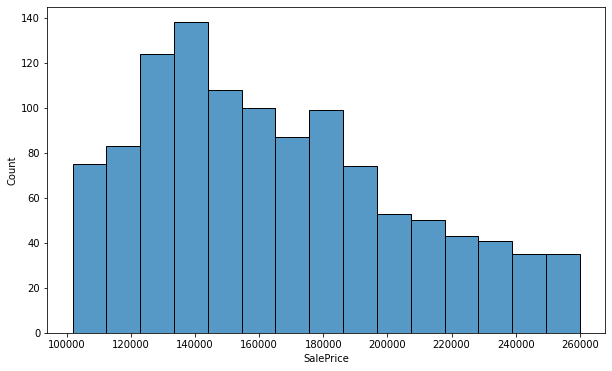

In [52]:
from sklearn.preprocessing import StandardScaler
from scipy import stats
from scipy.stats import norm
scaler = StandardScaler()
train_data_copy = train_data.copy()
scaled_prices = np.array(scaler.fit_transform(train_data_copy['SalePrice'][:, np.newaxis]))
train_data_copy['SalePriceScaled'] = scaled_prices[:,0]
indeces_to_drop = train_data_copy[(train_data_copy['SalePriceScaled'] < -1) | (train_data_copy['SalePriceScaled'] > 1)].index
train_data = train_data_copy.drop(indeces_to_drop)
train_data = train_data.drop(['SalePriceScaled'], axis=1)
plt.figure(1, figsize=(10,6))
sns.histplot(data=train_data['SalePrice'])
plt.show()

-----

## Analiza danych

Number of columns containing high correlation: 9


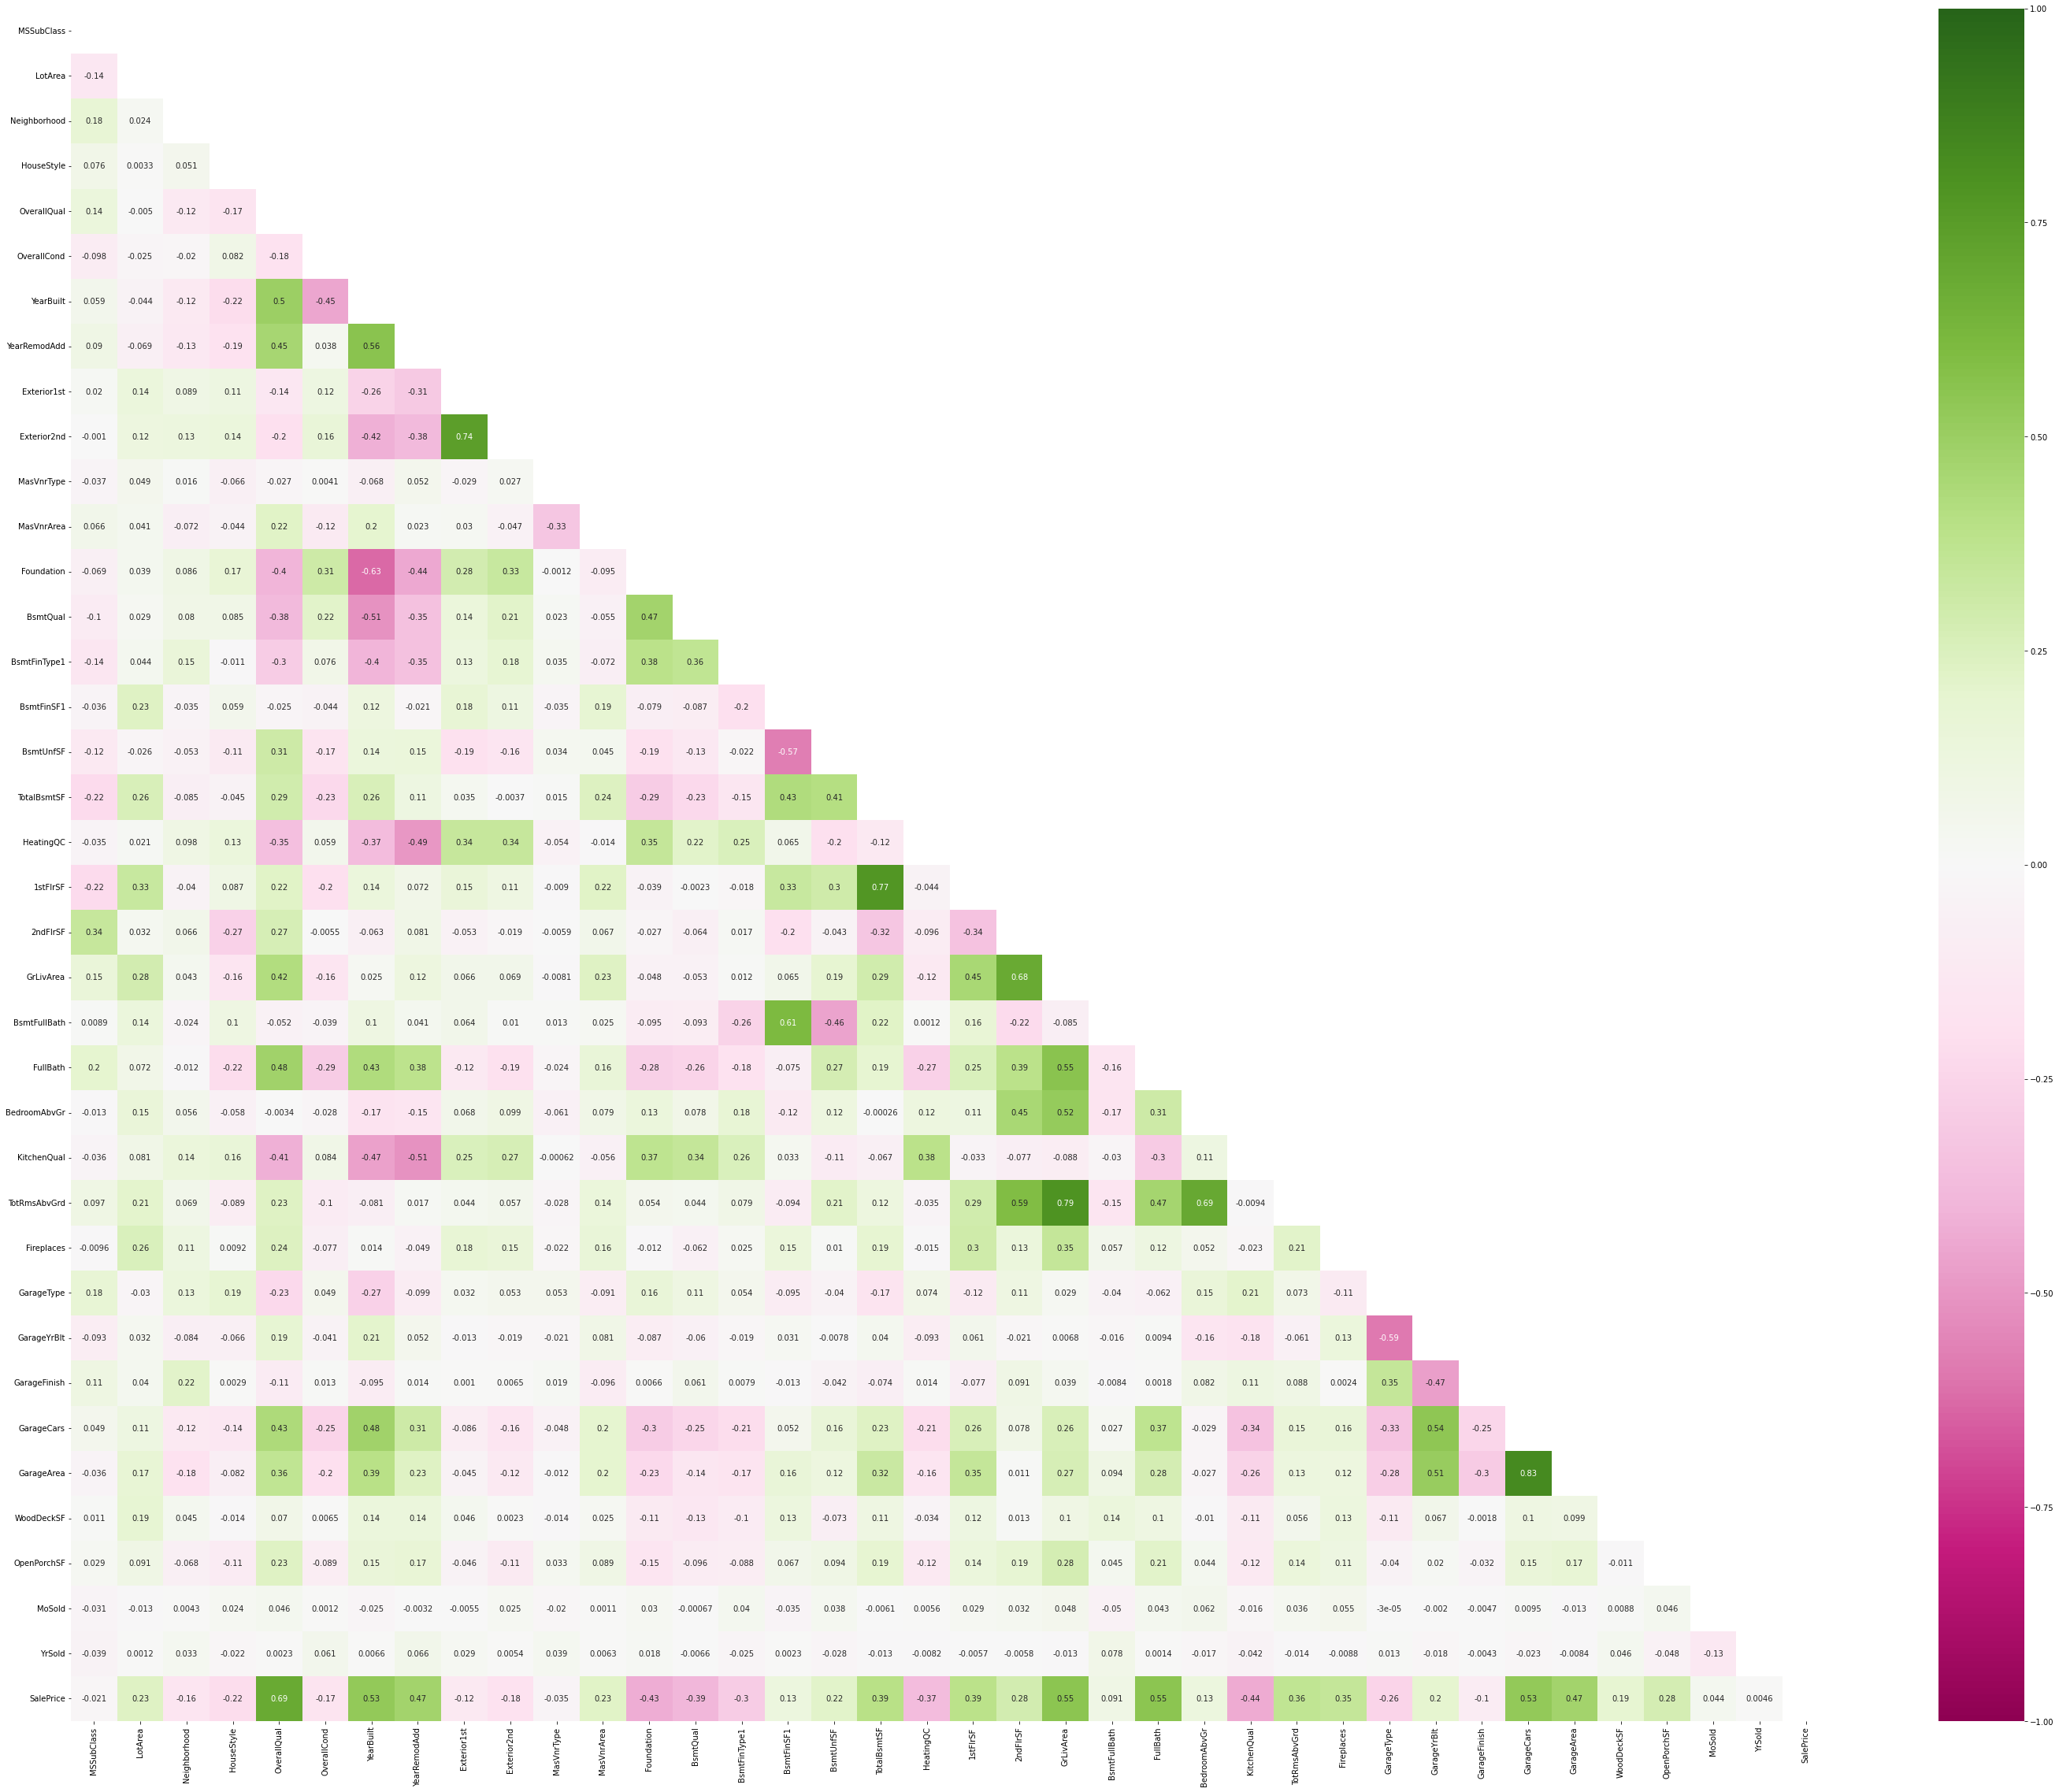

In [53]:
corr_threshold = 0.6
corr = train_data.corr()
lower_tri = corr.where(np.tril(np.ones(corr.shape),k=-1).astype(bool)) #creating lower triangular correlation matrix
f = plt.figure(figsize=(50, 40))
sns.heatmap(lower_tri, cmap="PiYG", annot=True, vmin=-1, vmax=1, ax=plt.gca())
high_corr = []
corr_columns = []
for column in train_data:
   for col in train_data:
     if abs(lower_tri[column][col]) > corr_threshold:
       if (col,column) not in corr_columns:
        corr_columns.append((column,col))

       high_corr.append((column, col, lower_tri[column][col]))
high_corr = sorted(high_corr, key=lambda x: x[2], reverse=True)
print("Number of columns containing high correlation:", len(set([x[0] for x in high_corr])))

In [54]:
train_data[[corr_columns[0][0], corr_columns[0][1]]]

,OverallQual,SalePrice
0,0.666667,208500
1,0.555556,181500
2,0.666667,223500
3,0.666667,140000
4,0.777778,250000
...,...,...
1454,0.666667,185000
1455,0.555556,175000
1456,0.555556,210000
1458,0.444444,142125


In [55]:
high_corr

[('GarageCars', 'GarageArea', 0.8322151800370637),
 ('GrLivArea', 'TotRmsAbvGrd', 0.793337984445501),
 ('TotalBsmtSF', '1stFlrSF', 0.7743429551204599),
 ('Exterior1st', 'Exterior2nd', 0.7411825569873141),
 ('BedroomAbvGr', 'TotRmsAbvGrd', 0.693687468049643),
 ('OverallQual', 'SalePrice', 0.6850701819335482),
 ('2ndFlrSF', 'GrLivArea', 0.6800806299161003),
 ('BsmtFinSF1', 'BsmtFullBath', 0.6060368259405682),
 ('YearBuilt', 'Foundation', -0.6290946344441545)]

##### Porzucenie kolumn z wysokim wskaźnikiem korelacji

In [56]:
# drop columns with high correlation
train_data = train_data.drop([x[0] for x in high_corr if x[0] in train_data], axis=1)
test_data_X = test_data_X.drop([x[0] for x in high_corr if x[0] in test_data_X], axis=1)

In [57]:
train_data_X = train_data.drop(['SalePrice'], axis=1)
train_data_Y = train_data.loc[:,["SalePrice"]].to_numpy()
test_data_Y = test_data_Y.to_numpy()

-----
-----

# Predykcja za pomocą różnych metod:


*   regresja liniowa
*   regresja z regularyzacją metodą Lasso
*   regresja za pomocą Random Forest w XGBoost



## Regresja Liniowa

In [58]:
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression

linear_model = LinearRegression()
linear_model.fit(train_data_X,train_data_Y)  
predicted = linear_model.predict(test_data_X)

In [59]:
def results_sum_up(actual_prices, predicted_prices, show_n_elements=15):
    relative_error_list = []
    for i, (actual, predicted) in enumerate(zip(actual_prices, predicted_prices)):
        try:
            #sometimes values are stored in 1D arrays so we need to access them
            actual = actual[0]
            predicted = predicted[0]
        except:
            pass
        relative_error = np.abs((actual - predicted)/actual)
        relative_error_list.append(relative_error)
        if i < show_n_elements:
            print(f"Actual: {actual:.2f}\tPrediction: {predicted:.2f}\t\tDifference: {(100*relative_error):.2f}%")

    return np.sqrt(mean_squared_error(actual_prices, predicted_prices)), relative_error_list

##### Wyniki regresji liniowej

In [60]:
rmse, relative_errors = results_sum_up(test_data_Y, predicted)
print(f"\nRMSE = {rmse:.2f}\t mean(relative_erors) = {np.mean(relative_errors)*100:.2f}%")

Actual: 169277.05	Prediction: 173314.02		Difference: 2.38%
Actual: 187758.39	Prediction: 166360.71		Difference: 11.40%
Actual: 183583.68	Prediction: 176165.42		Difference: 4.04%
Actual: 179317.48	Prediction: 176447.85		Difference: 1.60%
Actual: 150730.08	Prediction: 141020.74		Difference: 6.44%
Actual: 177150.99	Prediction: 171750.37		Difference: 3.05%
Actual: 172070.66	Prediction: 171641.78		Difference: 0.25%
Actual: 175110.96	Prediction: 167862.36		Difference: 4.14%
Actual: 162011.70	Prediction: 159922.29		Difference: 1.29%
Actual: 160726.25	Prediction: 158084.34		Difference: 1.64%
Actual: 157933.28	Prediction: 160813.14		Difference: 1.82%
Actual: 145291.25	Prediction: 126493.36		Difference: 12.94%
Actual: 159672.02	Prediction: 133163.29		Difference: 16.60%
Actual: 164167.52	Prediction: 160280.69		Difference: 2.37%
Actual: 150891.64	Prediction: 116991.93		Difference: 22.47%

RMSE = 31543.04	 mean(relative_erors) = 13.76%


-----

## Regresja z regularyzacją Lasso

In [61]:
from sklearn.linear_model import Lasso

regular_lasso_model = Lasso(alpha=0.005, max_iter=50000)
regular_lasso_model.fit(train_data_X, train_data_Y)
predicted = regular_lasso_model.predict(test_data_X)

##### Wyniki regresji z regularyzacją Lasso

In [62]:
rmse, relative_errors = results_sum_up(test_data_Y, predicted)
print(f"\nRMSE = {rmse:.2f}\t mean(relative_erors) = {np.mean(relative_errors)*100:.2f}%")

Actual: 169277.05	Prediction: 173313.11		Difference: 2.38%
Actual: 187758.39	Prediction: 166359.63		Difference: 11.40%
Actual: 183583.68	Prediction: 176164.68		Difference: 4.04%
Actual: 179317.48	Prediction: 176447.40		Difference: 1.60%
Actual: 150730.08	Prediction: 141020.70		Difference: 6.44%
Actual: 177150.99	Prediction: 171749.85		Difference: 3.05%
Actual: 172070.66	Prediction: 171641.35		Difference: 0.25%
Actual: 175110.96	Prediction: 167862.02		Difference: 4.14%
Actual: 162011.70	Prediction: 159921.73		Difference: 1.29%
Actual: 160726.25	Prediction: 158083.82		Difference: 1.64%
Actual: 157933.28	Prediction: 160812.97		Difference: 1.82%
Actual: 145291.25	Prediction: 126493.38		Difference: 12.94%
Actual: 159672.02	Prediction: 133163.31		Difference: 16.60%
Actual: 164167.52	Prediction: 160280.62		Difference: 2.37%
Actual: 150891.64	Prediction: 116991.82		Difference: 22.47%

RMSE = 31543.32	 mean(relative_erors) = 13.76%


-----

## Random Forest Regression

In [63]:
import xgboost as xgb

xgb_model = xgb.XGBRegressor(
                 colsample_bytree=0.05,
                 gamma=0.0,
                 learning_rate=0.0005,
                 max_depth=6,
                 min_child_weight=1.5,
                 n_estimators=7200,                                                                  
                 reg_alpha=0.9,
                 reg_lambda=0.6,
                 subsample=0.2,
                 seed=42)
xgb_model.fit(train_data_X, train_data_Y)
predicted = xgb_model.predict(test_data_X)

regular_lasso_model = Lasso(alpha=0.005, max_iter=50000)

##### Wyniki regresji z wykorzystaniem Random Forest w XGBoost

In [64]:
rmse, relative_errors = results_sum_up(test_data_Y, predicted)
print(f"\nRMSE = {rmse:.2f}\t mean(relative_erors) = {np.mean(relative_errors)*100:.2f}%")

Actual: 169277.05	Prediction: 170243.56		Difference: 0.57%
Actual: 187758.39	Prediction: 158221.33		Difference: 15.73%
Actual: 183583.68	Prediction: 169173.38		Difference: 7.85%
Actual: 179317.48	Prediction: 167866.42		Difference: 6.39%
Actual: 150730.08	Prediction: 163625.56		Difference: 8.56%
Actual: 177150.99	Prediction: 166339.33		Difference: 6.10%
Actual: 172070.66	Prediction: 159305.91		Difference: 7.42%
Actual: 175110.96	Prediction: 167080.97		Difference: 4.59%
Actual: 162011.70	Prediction: 160241.06		Difference: 1.09%
Actual: 160726.25	Prediction: 162263.36		Difference: 0.96%
Actual: 157933.28	Prediction: 164654.14		Difference: 4.26%
Actual: 145291.25	Prediction: 154468.50		Difference: 6.32%
Actual: 159672.02	Prediction: 153382.70		Difference: 3.94%
Actual: 164167.52	Prediction: 156801.36		Difference: 4.49%
Actual: 150891.64	Prediction: 150273.23		Difference: 0.41%

RMSE = 23746.27	 mean(relative_erors) = 10.55%


### Grid search po parametrach w celu wybrania najbardziej optymalnego zestawu

In [65]:
def mean_relative_error(actual_prices, predicted_prices):
    relative_error_list = []
    for i, (actual, predicted) in enumerate(zip(actual_prices, predicted_prices)):
        try:
            actual = actual[0]
            predicted = predicted[0]
        except:
            pass
        relative_error = np.abs((actual - predicted)/actual)
        relative_error_list.append(relative_error)

    return - np.mean(relative_error_list)*100

custom_scorer = make_scorer(mean_relative_error, greater_is_better=False)

In [66]:
# model = xgb.XGBRegressor(objective='reg:squarederror')
# parameters = {'nthread' : [4],              
#               'colsample_bytree' : list(np.arange(0.02, 0.1, 0.02)),
#               'gamma' : [0.0],
#               'learning_rate' : list(np.arange(0.0003, 0.0008, 0.0001)),
#               'max_depth' : list(np.arange(4, 9, 1)),
#               'min_child_weight' : [1.5],
#               'n_estimators' : list(np.arange(5000, 8000, 800)),
#               'reg_alpha' : [0.9],
#               'reg_lambda' : [0.6],
#               'subsample' : [0.2],
#               'seed' : [42] }


# model_xgb_grid = GridSearchCV(estimator=model,
#                         param_grid=parameters,
#                         # cv=2,
#                         n_jobs=8,
#                         scoring=custom_scorer,
#                         verbose=10
#                         )

# model_xgb_grid.fit(train_data_X, train_data_Y)

# print(model_xgb_grid.best_score_)
# print(model_xgb_grid.best_params_)

##### Wyniki Grid Search'a

Best parameters:

* przypadek bez usuniętych kolumn zawierających dużą ilość wartości NaN

{'colsample_bytree': 0.02, 'gamma': 0.0, 'learning_rate': 0.0005, 'max_depth': 4, 'min_child_weight': 1.5, 'n_estimators': 7400, 'nthread': 4, 'reg_alpha': 0.9, 'reg_lambda': 0.6, 'seed': 42, 'subsample': 0.2}

------

* z usuniętymi kolumnami z dużą ilością wartości NaN

{'colsample_bytree': 0.02, 'gamma': 0.0, 'learning_rate': 0.0006999999999999999, 'max_depth': 4, 'min_child_weight': 1.5, 'n_estimators': 5800, 'nthread': 4, 'reg_alpha': 0.9, 'reg_lambda': 0.6, 'seed': 42, 'subsample': 0.2}

##### Wytrenowanie modelu na znalezionym najlepszym zestawie parametrów

In [67]:
model = xgb.XGBRegressor(colsample_bytree=0.02,
                         gamma=0.0, 
                         learning_rate=0.0006999999999999999,
                         max_depth=4,
                         min_child_weight=1.5,
                         n_estimators=5800,
                         nthread=4,
                         reg_alpha=0.9,
                         reg_lambda=0.6,
                         seed=42,
                         subsample=0.2)

# model = xgb.XGBRegressor(
#     **model_xgb_grid.best_params_
# )
model.fit(train_data_X, train_data_Y)
predicted = model.predict(test_data_X)
rmse, relative_errors = results_sum_up(test_data_Y, predicted)
print("\nRMSE = {:.2f}\t mean(relative_erors) = {:.2f}%".format(rmse, np.mean(relative_errors)*100))

Actual: 169277.05	Prediction: 171904.27		Difference: 1.55%
Actual: 187758.39	Prediction: 159419.58		Difference: 15.09%
Actual: 183583.68	Prediction: 171387.75		Difference: 6.64%
Actual: 179317.48	Prediction: 170592.91		Difference: 4.87%
Actual: 150730.08	Prediction: 165508.42		Difference: 9.80%
Actual: 177150.99	Prediction: 167820.42		Difference: 5.27%
Actual: 172070.66	Prediction: 160491.86		Difference: 6.73%
Actual: 175110.96	Prediction: 168907.48		Difference: 3.54%
Actual: 162011.70	Prediction: 161639.00		Difference: 0.23%
Actual: 160726.25	Prediction: 163097.64		Difference: 1.48%
Actual: 157933.28	Prediction: 165933.16		Difference: 5.07%
Actual: 145291.25	Prediction: 155991.86		Difference: 7.36%
Actual: 159672.02	Prediction: 154489.12		Difference: 3.25%
Actual: 164167.52	Prediction: 158227.36		Difference: 3.62%
Actual: 150891.64	Prediction: 150633.72		Difference: 0.17%

RMSE = 22826.69	 mean(relative_erors) = 10.04%


-----

## Analiza SHAP

#### Regresja liniowa

Estimating transforms: 100%|██████████| 1000/1000 [00:01<00:00, 774.68it/s]


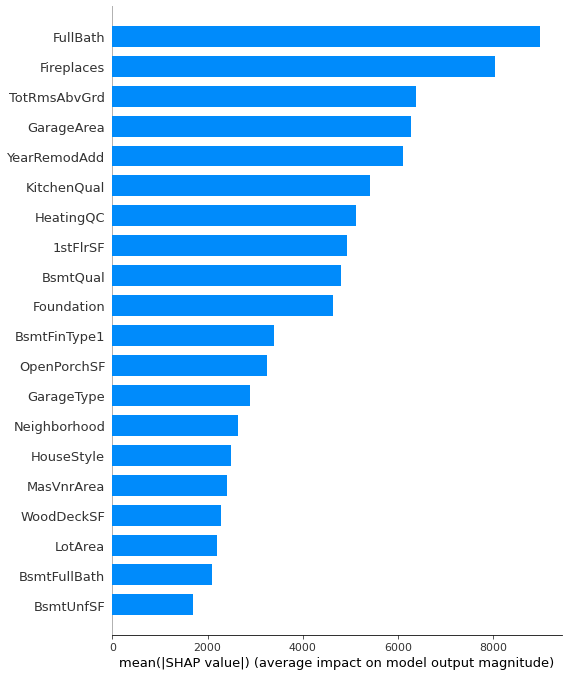

In [68]:
masker = shap.maskers.Impute(data=train_data_X)
shap_values = shap.explainers.Linear(linear_model, masker=masker).shap_values(train_data_X)
# shap_values = shap.TreeExplainer(linear_model).shap_values(train_data_X)
shap.summary_plot(shap_values, train_data_X, plot_type="bar")

#### Regresja z regularyzacją Lasso

In [ ]:
masker = shap.maskers.Impute(data=train_data_X)
shap_values = shap.explainers.Linear(regular_lasso_model, masker=masker).shap_values(train_data_X)
shap.summary_plot(shap_values, train_data_X, plot_type="bar")

#### Random Forest Regression

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


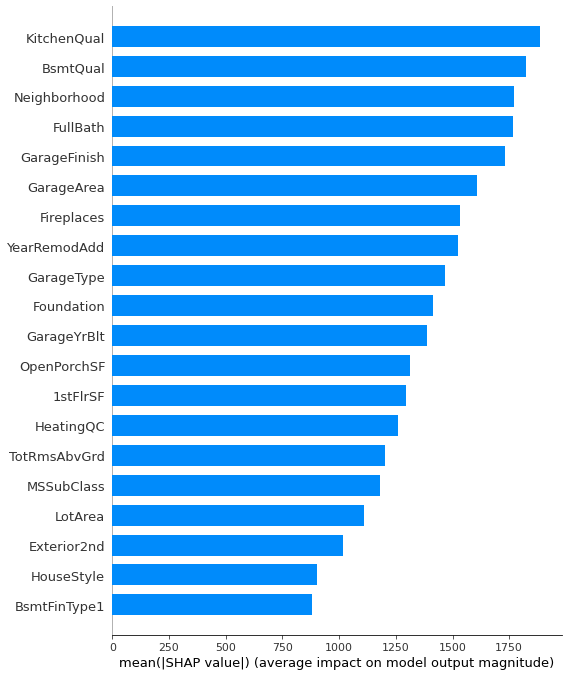

In [70]:
shap_values = shap.TreeExplainer(xgb_model).shap_values(train_data_X)
shap.summary_plot(shap_values, train_data_X, plot_type="bar")

In [ ]:
for x in train_data_X:
    print(x)

Street
Utilities
LotConfig
Neighborhood
Condition1
LowQualFinSF
BsmtHalfBath
Functional
EnclosedPorch
3SsnPorch
ScreenPorch
PoolArea
MiscVal
MoSold
YrSold
SaleCondition
